In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [2]:
class SegmentationTransforms:
    def __init__(self, image_size=(256, 256), degrees=15, scale=(0.8, 1.2), shear=10, contrast_range=(0.5, 1.0)):
        self.image_size = image_size
        self.degrees = degrees
        self.scale = scale
        self.shear = shear
        self.contrast_range = contrast_range  # new param for contrast factor range

    def __call__(self, image, mask):
        # Horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random affine transform
        angle = random.uniform(-self.degrees, self.degrees)
        translations = (0, 0)
        scale = random.uniform(self.scale[0], self.scale[1])
        shear = random.uniform(-self.shear, self.shear)
        image = TF.affine(image, angle=angle, translate=translations, scale=scale, shear=shear, fill=0)
        mask = TF.affine(mask, angle=angle, translate=translations, scale=scale, shear=shear, fill=0, interpolation=TF.InterpolationMode.NEAREST)

        # Random crop
        img_h, img_w = image.size[1], image.size[0]
        target_h, target_w = self.image_size
        crop_h = min(target_h, img_h)
        crop_w = min(target_w, img_w)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_h, crop_w))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Color jitter on image
        color_jitter = transforms.ColorJitter(0.2, 0.2, 0.2, 0.05)
        image = color_jitter(image)

        # Random contrast adjustment (factor between contrast_range)
        contrast_factor = random.uniform(self.contrast_range[0], self.contrast_range[1])
        image = TF.adjust_contrast(image, contrast_factor)

        # Optional: Gaussian blur on image only
        if random.random() > 0.7:
            image = TF.gaussian_blur(image, kernel_size=3)

        # Resize both to image_size
        image = TF.resize(image, self.image_size)
        mask = TF.resize(mask, self.image_size, interpolation=TF.InterpolationMode.NEAREST)

        return image, mask

In [3]:
def augment_dataset(src_img_dir, src_mask_dir, dst_img_dir, dst_mask_dir, augmentor, augmentations_per_image=5):
    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_mask_dir, exist_ok=True)

    img_filenames = [f for f in os.listdir(src_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    for img_name in img_filenames:
        img_path = os.path.join(src_img_dir, img_name)
        mask_path = os.path.join(src_mask_dir, img_name)

        if not os.path.exists(mask_path):
            print(f"Mask for image {img_name} not found, skipping.")
            continue

        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        for i in range(augmentations_per_image):
            aug_image, aug_mask = augmentor(image, mask)

            base_name, ext = os.path.splitext(img_name)
            aug_img_name = f"{base_name}_aug_{i+1}{ext}"

            aug_image.save(os.path.join(dst_img_dir, aug_img_name))
            aug_mask.save(os.path.join(dst_mask_dir, aug_img_name))

        print(f"Augmented {img_name} with {augmentations_per_image} samples.")

In [ ]:
src_images = "src/dataset/images"
src_masks = "src/dataset/masks"
dst_images = "src/dataset_aug/images"
dst_masks = "src/dataset_aug/masks"
augmentations_per_image = 5

augmentor = SegmentationTransforms(image_size=(25, 25))
augment_dataset(src_images, src_masks, dst_images, dst_masks, augmentor, augmentations_per_image)

Augmented Grain 1.png with 5 samples.
Augmented Grain 102.png with 5 samples.
Augmented Grain 114.png with 5 samples.
Augmented Grain 13.png with 5 samples.
Augmented Grain 17.png with 5 samples.
Augmented Grain 18.png with 5 samples.
Augmented Grain 2.png with 5 samples.
Augmented Grain 25.png with 5 samples.
Augmented Grain 3.png with 5 samples.
Augmented Grain 33.png with 5 samples.
Augmented Grain 35.png with 5 samples.
Augmented Grain 5.png with 5 samples.
Augmented Grain 6.png with 5 samples.
Augmented Grain 7.png with 5 samples.
Augmented Grain 76.png with 5 samples.
Augmented Grain 78.png with 5 samples.
Augmented Grain 79.png with 5 samples.
Augmented Grain 8.png with 5 samples.


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\William Pearson\AppData\Local\Temp\ipykernel_20372\2470872579.py:5: SyntaxWarning: invalid escape sequence '\d'
  image_path = "src\dataset\images\Grain 1.png"
C:\Users\William Pearson\AppData\Local\Temp\ipykernel_20372\2470872579.py:6: SyntaxWarning: invalid escape sequence '\d'
  mask_path = "src\dataset\masks\Grain 1.png"


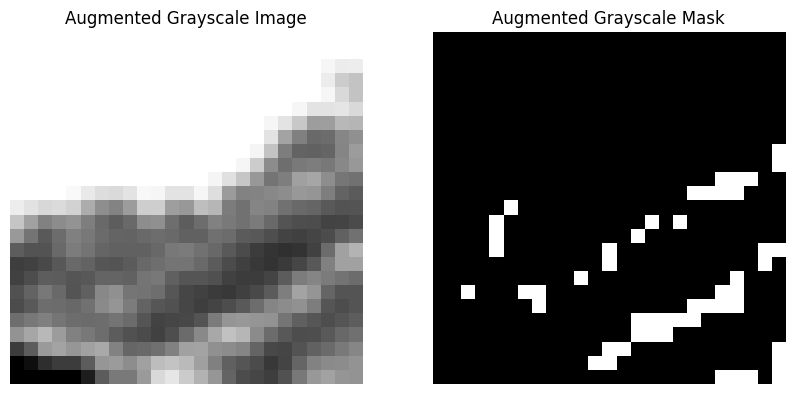

In [5]:
# Instantiate transform
augmentor = SegmentationTransforms(image_size=(25, 25))

#Paths
image_path = "src\dataset\images\Grain 1.png"
mask_path = "src\dataset\masks\Grain 1.png"

# Load image and mask
image = Image.open(image_path).convert('L')
mask = Image.open(mask_path).convert('L')

# Instantiate and apply transform
augmentor = SegmentationTransforms(image_size=(25, 25))
aug_image, aug_mask = augmentor(image, mask)

# Show results
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(aug_image, cmap='gray')
ax[0].set_title('Augmented Grayscale Image')
ax[0].axis('off')

ax[1].imshow(aug_mask, cmap='gray')
ax[1].set_title('Augmented Grayscale Mask')
ax[1].axis('off')

plt.show()

In [6]:
from PIL import Image
import os

def get_image_info(image_path):
    """Return (width, height, unique_pixels) of an image."""
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            pixels = list(img.getdata())
            unique_pixels = set(pixels)  # Get unique pixel values

            return width, height, unique_pixels
    except Exception as e:
        print(f"Error opening {image_path}: {e}")
        return None

def main():
    folder = "src/dataset_aug/masks"
    image_files = [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif", ".tiff"))
    ]

    for path in image_files:
        info = get_image_info(path)
        if info:
            print(f"{os.path.basename(path)}: {info[0]}×{info[1]} unique pixels — {info[2]}")

if __name__ == "__main__":
    main()

Grain 102_aug_1.png: 25×25 unique pixels — {0, 255}
Grain 102_aug_2.png: 25×25 unique pixels — {0, 255}
Grain 102_aug_3.png: 25×25 unique pixels — {0, 255}
Grain 102_aug_4.png: 25×25 unique pixels — {0, 255}
Grain 102_aug_5.png: 25×25 unique pixels — {0, 255}
Grain 114_aug_1.png: 25×25 unique pixels — {0, 255}
Grain 114_aug_2.png: 25×25 unique pixels — {0, 255}
Grain 114_aug_3.png: 25×25 unique pixels — {0, 255}
Grain 114_aug_4.png: 25×25 unique pixels — {0, 255}
Grain 114_aug_5.png: 25×25 unique pixels — {0, 255}
Grain 13_aug_1.png: 25×25 unique pixels — {0, 255}
Grain 13_aug_2.png: 25×25 unique pixels — {0, 255}
Grain 13_aug_3.png: 25×25 unique pixels — {0, 255}
Grain 13_aug_4.png: 25×25 unique pixels — {0, 255}
Grain 13_aug_5.png: 25×25 unique pixels — {0, 255}
Grain 17_aug_1.png: 25×25 unique pixels — {0, 255}
Grain 17_aug_2.png: 25×25 unique pixels — {0, 255}
Grain 17_aug_3.png: 25×25 unique pixels — {0, 255}
Grain 17_aug_4.png: 25×25 unique pixels — {0, 255}
Grain 17_aug_5.png: 2

In [ ]:
from PIL import Image
import numpy as np
import os

def binarize_mask(image_path, save_path=None, threshold=128):
    """
    Convert an image to a binary mask (0 or 1).
    
    Args:
        image_path (str): Path to the input image.
        save_path (str, optional): Path to save the binary mask. 
            If None, it overwrites the original image.
        threshold (int): Pixel value threshold to separate 0 and 1.
    """
    try:
        # Open image and convert to grayscale
        with Image.open(image_path) as img:
            gray = img.convert("L")  # convert to grayscale
            arr = np.array(gray)

            # Apply threshold to create binary mask
            binary_arr = np.where(arr >= threshold, 1, 0).astype(np.uint8)

            # Convert back to image
            binary_img = Image.fromarray(binary_arr)  # multiply by 255 for saving as visible mask

            # Save image
            if save_path is None:
                save_path = image_path
            binary_img.save(save_path)
            print(f"Saved binary mask: {save_path}")

    except Exception as e:
        print(f"Error processing {image_path}: {e}")


def main():
    folder = "src/dataset_aug2/masks"
    output_folder = "src/dataset_aug/binary_masks"
    os.makedirs(output_folder, exist_ok=True)

    image_files = [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff"))
    ]

    for path in image_files:
        filename = os.path.basename(path)
        save_path = os.path.join(output_folder, filename)
        binarize_mask(path, save_path)

if __name__ == "__main__":
    main()

Saved binary mask: src/dataset_aug2/binary_masks\Grain 102_aug_1.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 102_aug_2.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 102_aug_3.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 102_aug_4.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 102_aug_5.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 114_aug_1.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 114_aug_2.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 114_aug_3.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 114_aug_4.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 114_aug_5.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 13_aug_1.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 13_aug_2.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 13_aug_3.png
Saved binary mask: src/dataset_aug2/binary_masks\Grain 13_aug_4.png
Saved binary mask: src/dataset_aug2/bi